In [1]:
import pandas as pd
import numpy as np
import collections
import itertools
import requests
import tqdm

import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

import regex as re

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\grace\\Desktop\\horror_stories\\utils.py'>

# Load Data

In [3]:
stories = pd.read_csv('booksummaries.txt', sep='\t', header=None, names=['id', 'title', 'author', 'date', 'genre', 'summary'])
stories['date'] = pd.to_datetime(stories['date'], errors='coerce')
stories.reset_index(inplace=True, drop=True)

# clean genre column
genre = []
for g in stories.genre:
    if type(g) != str:
        g = ''
    else:
        glist = g.split(',')
        glist = [x.split(':')[1].strip('}" ').lower() for x in glist]
        # use regex to remove substrings that start with a backslash
        glist = [re.sub(r'\\.* ', '', x) for x in glist]
        g = {x for x in glist}
    genre.append(g)
stories['genre'] = genre

# make a column horror that is True if the story is horror
misc = {'alien','biopunk','cyberpunk','ghost','paranormal','science fantasy','speculative fiction','steampunk','supernatural','time travel','techno','time travel','vampire','zombie'}
stories['horror'] = stories.genre.apply(lambda x: 'horror' in str(x))
stories['scifi'] = stories.genre.apply(lambda x: 'science fiction' in str(x))
stories['gothic'] = stories.genre.apply(lambda x: 'gothic' in str(x))
stories['misc'] = stories.genre.apply(lambda x: sum([g in str(x) for g in misc]) > 0)
stories['scary'] = stories['horror'] | stories['scifi'] | stories['gothic'] | stories['misc']

# adjust dates for important books
stories.loc[stories.title == 'Frankenstein', 'date'] = pd.to_datetime('1818-01-01')

# SBERT

In [4]:
import faiss
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

from sklearn.manifold import TSNE

c:\Users\grace\Anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [176]:
# sbert = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
# embeddings = sbert.encode(stories.summary, show_progress_bar=True,convert_to_tensor=True)
# np.save('data/sbert_embeddings.npy',np.array(embeddings))
# emb = np.load('data/sbert_embeddings.npy')

Batches: 100%|██████████| 518/518 [1:42:12<00:00, 11.84s/it]  


In [5]:
# tsne_model = TSNE(perplexity=40, n_components=2, init='pca',
#                       n_iter=2500, random_state=23)
# sbert_pca = tsne_model.fit_transform(emb)
# np.save('data/sbert_pca.npy',sbert_pca)
sbert_pca = np.load('data/sbert_pca.npy')
sbert_pca = pd.DataFrame(sbert_pca, columns=['x1','x2'])
sbert_pca['year'] = stories.date.dt.year
sbert_pca['Year'] = pd.to_datetime(sbert_pca['year'], format='%Y')
sbert_pca['Title'] = stories.title
sbert_pca['Author'] = stories.author
sbert_pca['scary'] = stories.scary
sbert_pca['decade'] = sbert_pca['year'].apply(lambda x: str(x)[:3] + '0s')

In [6]:
old = alt.Chart(sbert_pca.query('scary and year < 1900')).mark_circle(opacity=1, size=10,color='#300b3a').encode(
    x='x1',
    y='x2',
    tooltip=['Title', 'Author', 'year']
).interactive()

# make a list of 12 hex colors from the magma color scheme
colors = ['#29114a','#1c185a','#20376b','#2a5f7b','#358b89','#419b78','#46ab66','#67bb5d','#99cb6d','#ccdc7e','#ecda90','#fccba4']
recent_decades = []
for i,decade in enumerate([str(x) + 's' for x in range(1900,2020,10)]):
    df = sbert_pca.query('scary and decade == @decade')
    decade_chart = alt.Chart(df).mark_circle(opacity=0.5, size=10,color=colors[i]).encode(
        x='x1',
        y='x2',
        tooltip=['Title', 'Author', 'year']
    ).interactive()
    recent_decades.append(decade_chart)
# make a legend
labels = [' <1900']
labels.extend([str(x) + 's' for x in range(1900,2020,10)])
c = ['#300b3a']
c.extend(colors)
legend = alt.Chart(pd.DataFrame({'decade':labels})).mark_circle(size=100, opacity=1).encode(
    y=alt.Y('decade:N', axis=alt.Axis(title='Decade')),
    color=alt.Color('decade:N', scale=alt.Scale(range=c), legend=None),
    order = alt.Order('decade', sort='ascending')
)
# combine the charts
recent_decades = alt.layer(*recent_decades, old).properties(width=300, height=300)
legend | recent_decades

alt.HConcatChart(...)

A majority of the speculative fiction books in this dataset were published after 1900. However, comparing the center of the older books to the center of the newer books, we can see that there was a shift in focus.

In [333]:
# plt.scatter(sbert_pca['x1'], sbert_pca['x2'], s=1, alpha=0.5, c=sbert_pca['year'], cmap='viridis')
# plt.colorbar()

# Text Cleaning

In [4]:
from gensim.utils import simple_preprocess
STOP = set(nltk.corpus.stopwords.words('english'))

In [5]:
# stories['lemmas'] = stories.summary.apply(lambda x: utils.get_lemmas(x))
# stories['lemmas'] = utils.make_bigrams(stories['lemmas'])
# stories['lemmas'].to_pickle('data\lemmas.pkl')
stories['lemmas'] = pd.read_pickle('data\lemmas.pkl').reset_index(drop=True)
stories['text'] = stories['lemmas'].apply(lambda x: ' '.join(x))

stories.reset_index(inplace=True)
stories['title'] = stories['title'].astype(str)
stories['author'] = stories['author'].astype(str)
stories['summary'] = stories['summary'].astype(str)
stories['text'] = stories['text'].astype(str)

# TF-IDF / LIWC

In [6]:
corpus = stories.text.values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

tfidf['Id'], tfidf['Year'], tfidf['Title'], tfidf['Author'], tfidf['Scary'] = stories.id, stories.date.dt.year, stories.title, stories.author, stories.scary

Baseline

In [13]:
# tfidf_mean = tfidf[tfidf.columns[1719:-500]].mean(axis=0)
# tfidf_mean.to_csv('data/tfidf_mean.csv')
tfidf_mean = pd.read_csv('data/tfidf_mean.csv',index_col=0).rename(columns={'0':'tfidf'})
relevant = list(tfidf_mean.sort_values('tfidf', ascending=False).head(100).index)

# cols = list(tfidf.columns[1719:-500])
# cols.extend(['Year'])
# tfidf_old_mean = tfidf[cols].query('Year < 1900').mean(axis=0)
# tfidf_old_mean.to_csv('data/tfidf_old_mean.csv')
tfidf_old_mean = pd.read_csv('data/tfidf_old_mean.csv',index_col=0).rename(columns={'0':'tfidf'})
old_relevant = list(tfidf_old_mean.sort_values('tfidf', ascending=False).head(100).index)

In [14]:
# tfidf_relevant = stories[['id','date','title','author','scary']]
# tfidf_relevant['TF-IDF'] = tfidf[relevant].sum(axis=1)
# tfidf_relevant['year'] = tfidf_relevant.date.dt.year
# tfidf_relevant.to_csv('data/tfidf_relevant.csv', index=False)
tfidf_relevant = pd.read_csv('data/tfidf_relevant.csv').rename(columns={'TF-IDF':'tfidf'})
relevant = tfidf_relevant.query('tfidf > 0')
relevant['Genre'] = relevant['scary'].apply(lambda x: 'Horror, Sci-Fi, or Gothic' if x else 'Other')
relevant_freq = (relevant.query('not scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('not scary')))
relevant_freq = relevant_freq.reset_index().rename(columns={'tfidf':'freq'})
relevant_scary_freq = (relevant.query('scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('scary')))
relevant_scary_freq = relevant_scary_freq.reset_index().rename(columns={'tfidf':'freq'})
relevant_freq['year'], relevant_scary_freq['year'] = pd.to_datetime(relevant_freq['year'], format='%Y'), pd.to_datetime(relevant_scary_freq['year'], format='%Y')

C:\Users\grace\AppData\Local\Temp\ipykernel_27348\395292460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_relevant['TF-IDF'] = tfidf[relevant].sum(axis=1)
C:\Users\grace\AppData\Local\Temp\ipykernel_27348\395292460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_relevant['year'] = tfidf_relevant.date.dt.year
C:\Users\grace\AppData\Local\Temp\ipykernel_27348\395292460.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [20]:
line_all = alt.Chart(relevant_freq).transform_window(
    rolling_mean='mean(freq)',
    frame=[-2, 3]
).mark_line(color='cornflowerblue').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title='% of Stories with Sampled Words')
)
line_scary = alt.Chart(relevant_scary_freq).transform_window(
    rolling_mean='mean(freq)',
    frame=[-2, 3]
).mark_line(color='maroon').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title='% of Stories with Sampled Words')
)
dots = alt.Chart(relevant.sample(frac=0.2, random_state=1)).mark_circle(size=30,opacity=0.5).encode(
    x=alt.X('date:T', title='Year'),
    y=alt.Y('tfidf', title='Sampled Words TF-IDF'),
    color=alt.Color('Genre', scale=alt.Scale(domain=['Horror, Sci-Fi, or Gothic', 'Other'], range=['maroon', 'cornflowerblue'])),
    # color=alt.Color('Genre', title='Genre', scale=alt.Scale(domain=[True, False], range=['maroon', 'cornflowerblue'])),
    tooltip=alt.Tooltip(['title', 'author'])
)
line_all + line_scary | dots

alt.HConcatChart(...)

Monsters

In [16]:
# monster_synonyms = ['monster','vampire','beast','brute','creature','ghoul','demon','goblin','devil','ghost','werewolf']
# monster_synonyms = [x for x in monster_synonyms if x in tfidf.columns]
# tfidf_monster = stories[['id','date','title','author','scary']]
# tfidf_monster['TF-IDF'] = tfidf[monster_synonyms].sum(axis=1)
# tfidf_monster['year'] = tfidf_monster.date.dt.year
# tfidf_monster.to_csv('data/tfidf_monster.csv', index=False)
tfidf_monster = pd.read_csv('data/tfidf_monster.csv').rename(columns={'TF-IDF':'tfidf'})
monster = tfidf_monster.query('tfidf > 0 and year > 1750')
monster['Genre'] = monster['scary'].apply(lambda x: 'Horror, Sci-Fi, or Gothic' if x else 'Other')
monster_freq = (monster.query('not scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('not scary')))
monster_freq = monster_freq.reset_index().rename(columns={'tfidf':'freq'}) 
monster_scary_freq = (monster.query('scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('scary')))
monster_scary_freq = monster_scary_freq.reset_index().rename(columns={'tfidf':'freq'})
monster_freq['year'], monster_scary_freq['year'] = pd.to_datetime(monster_freq['year'], format='%Y'), pd.to_datetime(monster_scary_freq['year'], format='%Y')
monster_freq['adjusted'], monster_scary_freq['adjusted'] = monster_freq['freq'] - relevant_freq['freq'], monster_scary_freq['freq'] - relevant_scary_freq['freq']

C:\Users\grace\AppData\Local\Temp\ipykernel_27348\2651471565.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monster['Genre'] = monster['scary'].apply(lambda x: 'Horror, Sci-Fi, or Gothic' if x else 'Other')


In [100]:
line_all = alt.Chart(monster_freq).transform_window(
    rolling_mean='mean(adjusted)',
    frame=[-2, 3]
).mark_line(color='cornflowerblue').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title="% of Stories about Monsters (Adjusted)")
)
line_scary = alt.Chart(monster_scary_freq).transform_window(
    rolling_mean='mean(adjusted)',
    frame=[-2, 3]
).mark_line(color='maroon').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title="% of Stories about Monsters (Adjusted)")
)
dots = alt.Chart(monster).mark_circle(size=30,opacity=0.5).encode(
    x=alt.X('date:T', title='Year'),
    y=alt.Y('tfidf', title='Monster TF-IDF'),
    color=alt.Color('Genre', scale=alt.Scale(domain=['Horror, Sci-Fi, or Gothic','Other'], range=['maroon', 'cornflowerblue'])),
    # color=alt.Color('Genre', title='Genre', scale=alt.Scale(domain=[True, False], range=['maroon', 'cornflowerblue'])),
    tooltip=alt.Tooltip(['title', 'author'])
)
line_scary + line_all | dots
# cold_war

alt.HConcatChart(...)

In [103]:
# robot_synonyms = ['robot','andriod','cyborg', 'automaton', 'droid', 'humanoid']
# robot_synonyms = [x for x in robot_synonyms if x in tfidf.columns]
# tfidf_robot = stories[['id','date','title','author','scary']]
# tfidf_robot['TF-IDF'] = tfidf[robot_synonyms].sum(axis=1)
# tfidf_robot['year'] = tfidf_robot.date.dt.year
# tfidf_robot.to_csv('data/tfidf_robot.csv', index=False)
tfidf_robot = pd.read_csv('data/tfidf_robot.csv').rename(columns={'TF-IDF':'tfidf'})
robot = tfidf_robot.query('year > 1920 and tfidf > 0')
robot['Genre'] = robot['scary'].apply(lambda x: 'Horror, Sci-Fi, or Gothic' if x else 'Other')
robot_freq = (robot.query('not scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('not scary')))
robot_freq = robot_freq.reset_index().rename(columns={'tfidf':'freq'})
robot_scary_freq = (robot.query('scary')[['year','tfidf']].groupby('year').count()*100 / len(stories.query('scary')))
robot_scary_freq = robot_scary_freq.reset_index().rename(columns={'tfidf':'freq'})
robot_freq['year'], robot_scary_freq['year'] = pd.to_datetime(robot_freq['year'], format='%Y'), pd.to_datetime(robot_scary_freq['year'], format='%Y')
robot_freq['adjusted'], robot_scary_freq['adjusted'] = robot_freq['freq'] - relevant_freq['freq'], robot_scary_freq['freq'] - relevant_scary_freq['freq']

C:\Users\grace\AppData\Local\Temp\ipykernel_27348\1743092332.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robot['Genre'] = robot['scary'].apply(lambda x: 'Horror, Sci-Fi, or Gothic' if x else 'Other')


In [104]:
line_all = alt.Chart(robot_freq).transform_window(
    rolling_mean='mean(adjusted)',
    frame=[-2,3]
).mark_line(color='cornflowerblue').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title='% of Stories about Robots (Adjusted)')
)
line_scary = alt.Chart(robot_scary_freq).transform_window(
    rolling_mean='mean(adjusted)',
    frame=[-2,3]
).mark_line(color='maroon').encode(
    x=alt.X('year:T', title='Year'),
    y=alt.Y('rolling_mean:Q', title='% of Stories about Robots (Adjusted)')
)
dots = alt.Chart(robot).mark_circle(size=30,opacity=0.5).encode(
    x=alt.X('date:T', title='Year'),
    y=alt.Y('tfidf', title='Robot TF-IDF'),
    color=alt.Color('Genre', scale=alt.Scale(domain=['Horror, Sci-Fi, or Gothic', 'Other'], range=['maroon', 'cornflowerblue'])),
    # color=alt.Color('Genre', title='Genre', scale=alt.Scale(domain=[True, False], range=['maroon', 'cornflowerblue'])),
    tooltip=alt.Tooltip(['title', 'author'])
)
line_scary + line_all | dots

alt.HConcatChart(...)

In [25]:
# liwc = utils.readDict('data/LIWC2007_English100131.dic')
# stories_liwc = pd.DataFrame()
# for i in tqdm.tqdm(stories.index):
#     text = stories['text'][i]
#     liwc_counts = utils.wordCount(text, liwc)
#     liwc_df =  pd.DataFrame(list(liwc_counts[0].items())).set_index(0) / liwc_counts[2]
#     liwc_df.columns = [stories.loc[i,'id']]
#     stories_liwc = pd.concat([stories_liwc,liwc_df],axis=1)
# stories_liwc = stories_liwc.T
# stories_liwc.to_csv('data/stories_liwc.csv')
stories_liwc = pd.read_csv('data/stories_liwc.csv', index_col=0)
stories_liwc.reset_index(inplace=True, drop=True)
stories_liwc['Year'], stories_liwc['Title'], stories_liwc['Author'], stories_liwc['Scary'] = stories.date.dt.year, stories.title, stories.author, stories.scary

In [90]:
liwc = utils.readDict('data/LIWC2007_English100131.dic')

In [91]:
test = utils.wordCount('i love you', liwc)

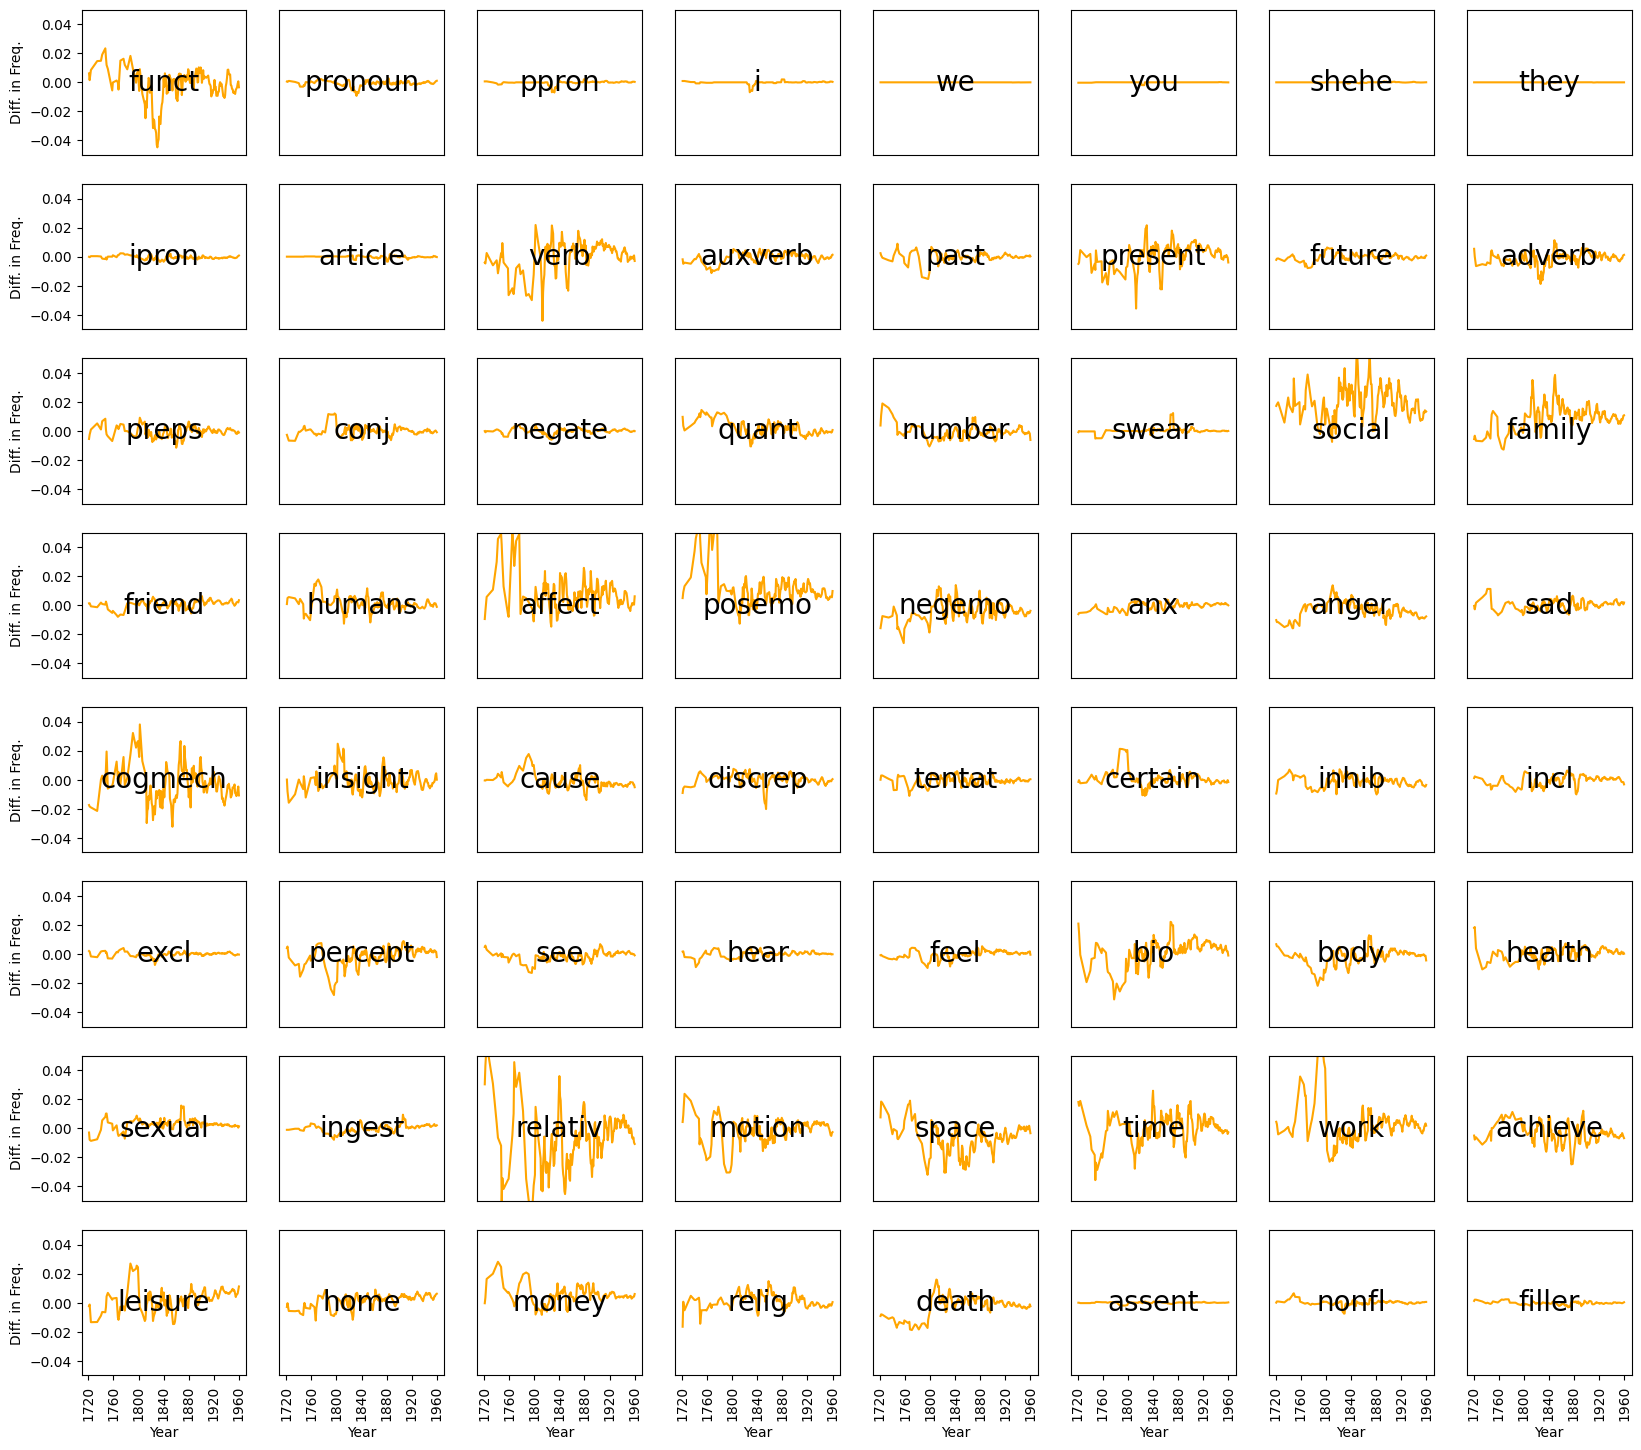

In [109]:
# stories_liwc = stories_liwc.query('not Scary').groupby('Year').mean()
# stories_liwc_year = stories_liwc.reset_index()
# stories_liwc_year['Year'] = pd.to_datetime(stories_liwc_year['Year'], format='%Y')

# stories_liwc_scary_year = stories_liwc.query('Scary').groupby('Year').mean()
# stories_liwc_scary_year = stories_liwc_scary_year.reset_index()
# stories_liwc_scary_year['Year'] = pd.to_datetime(stories_liwc_scary_year['Year'], format='%Y')

plt.figure(figsize=(20,20))
for i,col in enumerate(stories_liwc_year.columns[1:-1]):
    plt.subplot(9,8,i+1)
    plt.plot(stories_liwc_year['Year'], (stories_liwc_year[col] - stories_liwc_scary_year[col]).rolling(5).mean(), color='orange')
    plt.ylim(-0.05,0.05)
    plt.xticks(rotation=90)
    plt.text(0.5, 0.5, col, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, size=20)
    if i < 56:
        plt.xticks([])
    else:
        plt.xlabel('Year')
    if i % 8 != 0:
        plt.yticks([])
    else:
        plt.ylabel('Diff. in Freq.')
plt.show()

# Amazon Reviews

## Text Cleaning

In [4]:
amazon_books = pd.read_csv('data/amazon/books_data.csv')
amazon_books['Title'].fillna('', inplace=True)
amazon_books['clean_title'] = amazon_books['Title'].apply(lambda x: utils.clean_title(x))
amazon_reviews = pd.read_csv('data/amazon/books_rating.csv')
amazon_reviews = pd.merge(amazon_reviews, amazon_books[['Title','clean_title','authors','publishedDate']], left_on='Title',right_on='Title', how='left')
amazon_reviews['Title'].fillna('', inplace=True)
amazon_reviews['authors'].fillna('', inplace=True)

stories['clean_title'] = stories['title'].apply(lambda x: utils.clean_title(x))

amazon_reviews['clean_title'].fillna('', inplace=True)
stories['clean_title'].fillna('', inplace=True)

In [20]:
# find titles that are in both
amazon_titles = set(amazon_reviews['clean_title'].unique())
stories_titles = set(stories['clean_title'].unique())
overlap_titles = amazon_titles.intersection(stories_titles)

In [33]:
amazon_reviews.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text',
       'clean_title', 'authors', 'publishedDate'],
      dtype='object')

In [35]:
reviews = amazon_reviews.query('clean_title in @overlap_titles')
reviews = pd.merge(reviews[['clean_title','review/text','publishedDate']], stories[['clean_title','title','scary','author','date','genre','scary']], left_on='clean_title', right_on='clean_title', how='left')
reviews.rename(columns={'review/text':'review', 'publishedDate':'date_a'}, inplace=True)

In [44]:
reviews_scary = reviews.query('scary')

In [53]:
# l = []
# for x in tqdm.tqdm(reviews.query('scary')['review']):
#     l.append(utils.get_lemmas(x))
# reviews_scary['lemmas'] = l
pd.to_pickle(reviews_scary['lemmas'], 'data/review_lemmas.pkl')


100%|██████████| 364546/364546 [2:22:07<00:00, 42.75it/s]  


In [64]:
pd.to_pickle(reviews_scary['lemmas'], 'data/review_lemmas.pkl')

In [71]:
# reviews_scary['lemmas'] = pd.read_pickle('data/review_lemmas.pkl')
reviews_scary['text'] = reviews_scary['lemmas'].apply(lambda x: ' '.join(x))

C:\Users\grace\AppData\Local\Temp\ipykernel_1760\2793051266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_scary['text'] = reviews_scary['lemmas'].apply(lambda x: ' '.join(x))


In [99]:
reviews_corpus = reviews_scary.text.values
vectorizer_reviews = TfidfVectorizer()
X_reviews = vectorizer_reviews.fit_transform(reviews_corpus)
review_cols = vectorizer_reviews.get_feature_names_out()

In [169]:
frankenstein_review_idx = reviews_scary.reset_index().query('title == "Frankenstein"').index

frankenstein_context_idx = ['galvanism','rosseau','race','slavery','slave','imperialism','abolition','abolitionist']
frankenstein_context_idx = [np.where(review_cols == x)[0][0] for x in frankenstein_context_idx if x in review_cols]

X_frankenstein = X_reviews[frankenstein_review_idx]
X_frankenstein.toarray().mean(axis=0)
# X_frankenstein[:,frankenstein_context_idx].toarray().mean(axis=0)

tfidf_frankenstein = pd.DataFrame(X_frankenstein.toarray(), columns=review_cols)

In [175]:
reviews_scary.query('title == "Frankenstein"').query('review.str.contains("galvanism")')['review']

61800     Well, this is only the second work of fiction ...
62133     It was a real pleasure to reread the founding ...
62214     "F***ing Frankenstein" is the way to go, by fa...
62348     Frankenstein conjures us lurid images of Boris...
524804    "F***ing Frankenstein" is the way to go, by fa...
524968    Frankenstein conjures us lurid images of Boris...
525162    Well, this is only the second work of fiction ...
525444    It was a real pleasure to reread the founding ...
Name: review, dtype: object

In [172]:
print(X_frankenstein[:,frankenstein_context_idx].toarray().sum(axis=0))
review_cols[frankenstein_context_idx]

[0.9831628  0.         2.53565699 0.         0.54285061 0.
 0.         0.        ]


array(['galvanism', 'rosseau', 'race', 'slavery', 'slave', 'imperialism',
       'abolition', 'abolitionist'], dtype=object)